_Neural Data Science_

Lecturer: Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Rita González Márquez, Fabio Seel

Summer term 2024

Name: FILL IN YOUR NAMES HERE

# Coding Lab 7 : Transcriptomics



In [1]:
import numpy as np
import pylab as plt
import pandas as pd
import matplotlib.pyplot as plt

# We recommend using openTSNE for experiments with t-SNE
# https://github.com/pavlin-policar/openTSNE
from openTSNE import TSNE

%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

Last updated: 2024-06-21 08:17:33CEST

Python implementation: CPython
Python version       : 3.10.14
IPython version      : 8.23.0

sklearn: 1.4.2

matplotlib: 3.8.4
numpy     : 1.26.4
pandas    : 2.2.2

Watermark: 2.4.3



In [2]:
plt.style.use("../matplotlib_style.txt")

## Load data

Download the data from ILIAS, move it to the `data` directory and unzip it there.

In [3]:
# LOAD HARRIS ET AL DATA

# Load gene counts
data = pd.read_csv("../data/nds_cl_7/harris-data/expression.tsv.gz", sep="\t")
genes = data.values[:, 0]
cells = data.columns[1:-1]
counts = data.values[:, 1:-1].transpose().astype("int")
data = []

# Kick out all genes with all counts = 0
genes = genes[counts.sum(axis=0) > 0]
counts = counts[:, counts.sum(axis=0) > 0]
print(counts.shape)

# Load clustering results
data = pd.read_csv("../data/nds_cl_7/harris-data/analysis_results.tsv", sep="\t")
clusterNames, clusters = np.unique(data.values[0, 1:-1], return_inverse=True)

# Load cluster colors
data = pd.read_csv("../data/nds_cl_7/harris-data/colormap.txt", sep="\s+", header=None)
clusterColors = data.values

# Note: the color order needs to be reversed to match the publication
clusterColors = clusterColors[::-1]

# Taken from Figure 1 - we need cluster order to get correct color order
clusterOrder = [
    "Sst.No",
    "Sst.Npy.C",
    "Sst.Npy.Z",
    "Sst.Npy.S",
    "Sst.Npy.M",
    "Sst.Pnoc.Calb1.I",
    "Sst.Pnoc.Calb1.P",
    "Sst.Pnoc.P",
    "Sst.Erbb4.R",
    "Sst.Erbb4.C",
    "Sst.Erbb4.T",
    "Pvalb.Tac1.N",
    "Pvalb.Tac1.Ss",
    "Pvalb.Tac1.Sy",
    "Pvalb.Tac1.A",
    "Pvalb.C1ql1.P",
    "Pvalb.C1ql1.C",
    "Pvalb.C1ql1.N",
    "Cacna2d1.Lhx6.R",
    "Cacna2d1.Lhx6.V",
    "Cacna2d1.Ndnf.N",
    "Cacna2d1.Ndnf.R",
    "Cacna2d1.Ndnf.C",
    "Calb2.Cry",
    "Sst.Cry",
    "Ntng1.S",
    "Ntng1.R",
    "Ntng1.C",
    "Cck.Sema",
    "Cck.Lmo1.N",
    "Cck.Calca",
    "Cck.Lmo1.Vip.F",
    "Cck.Lmo1.Vip.C",
    "Cck.Lmo1.Vip.T",
    "Cck.Ly",
    "Cck.Cxcl14.Calb1.Tn",
    "Cck.Cxcl14.Calb1.I",
    "Cck.Cxcl14.S",
    "Cck.Cxcl14.Calb1.K",
    "Cck.Cxcl14.Calb1.Ta",
    "Cck.Cxcl14.V",
    "Vip.Crh.P",
    "Vip.Crh.C1",
    "Calb2.Vip.G",
    "Calb2.Vip.I",
    "Calb2.Vip.Nos1",
    "Calb2.Cntnap5a.R",
    "Calb2.Cntnap5a.V",
    "Calb2.Cntnap5a.I",
]

reorder = np.zeros(clusterNames.size) * np.nan
for i, c in enumerate(clusterNames):
    for j, k in enumerate(clusterOrder):
        if c[: len(k)] == k:
            reorder[i] = j
            break
clusterColors = clusterColors[reorder.astype(int)]

(3663, 17965)


In [10]:
data.head()

,0,1,2
0,0.7692,0.0000,0.0
1,0.7134,0.0726,0.0
2,0.6652,0.1353,0.0
3,0.6230,0.1901,0.0
4,0.5859,0.2383,0.0


In [4]:
print(genes)
print(cells)
print(genes.shape)
print(cells.shape)

['Xkr4' 'Gm1992' 'Sox17' ... 'PISD' 'DHRSX' 'CAAA01147332.1']
Index(['Kevontae', 'Krishav', 'Zinachidi', 'Eliott', 'Fitzgerald', 'Kamaria',
       'Hatch', 'Nana', 'Bindi', 'Avalyn',
       ...
       'Margie', 'Eshaal', 'Dionne', 'Marlina', 'Melynie', 'Makensey',
       'Marzia', 'Tulip', 'Ladale', 'Taequan'],
      dtype='object', length=3663)
(17965,)
(3663,)


## 1. Data inspection
Before we use t-SNE or any other advanced visualization methods on the data, we first want to have a closer look on the data and plot some statistics. For most of the analysis we will compare the data to a Poisson distribution.

###  1.1. Relationship between expression mean and fraction of zeros
The higher the average expression of a gene, the smaller fraction of cells will show a 0 count. 


_(2pt.)_

In [4]:
# ------------------------------------------------------
# Compute actual and predicted gene expression (1.5 pts)
# ------------------------------------------------------

# Compute the average expression for each gene
avg_expr = counts.mean(axis=0)

# Compute the fraction of zeros for each gene
fraq_zero = 1 - counts.astype(bool).mean(axis=0)

In [5]:
# Compute the Poisson prediction

# (what is the expected fraction of zeros in a Poisson distribution with a given mean?)
exp_fraq_zero = np.exp(-avg_expr)

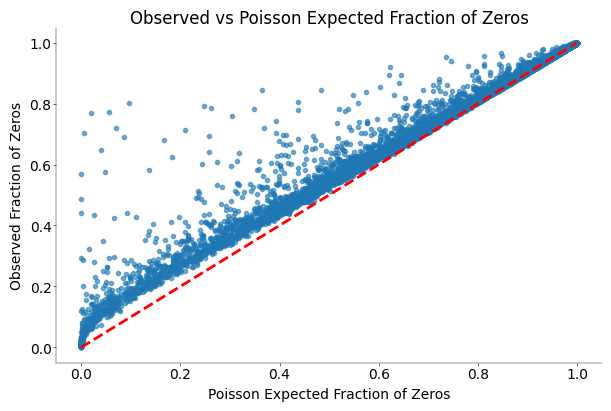

In [6]:
# --------------------------------------------------
# plot the data and the Poisson prediction (0.5 pts)
# --------------------------------------------------

fig, ax = plt.subplots(figsize=(6, 4))
# add plot

# Scatter plot of observed vs predicted
ax.scatter(exp_fraq_zero, fraq_zero, alpha=0.6)

# Add a diagonal line
min_val = min(exp_fraq_zero.min(), fraq_zero.min())
max_val = max(exp_fraq_zero.max(), fraq_zero.max())
ax.plot([min_val, max_val], [min_val, max_val], "r--", lw=2)

# Labels and title
ax.set_xlabel("Poisson Expected Fraction of Zeros")
ax.set_ylabel("Observed Fraction of Zeros")
ax.set_title("Observed vs Poisson Expected Fraction of Zeros")

# Display the plot
plt.show()

### 1.2. Mean-variance relationship

If the expression follows Poisson distribution, then the mean should be equal to the variance.

_(1pt.)_

In [7]:
# Compute the variance of the expression counts of each gene
var_gene = counts.var(axis=0)

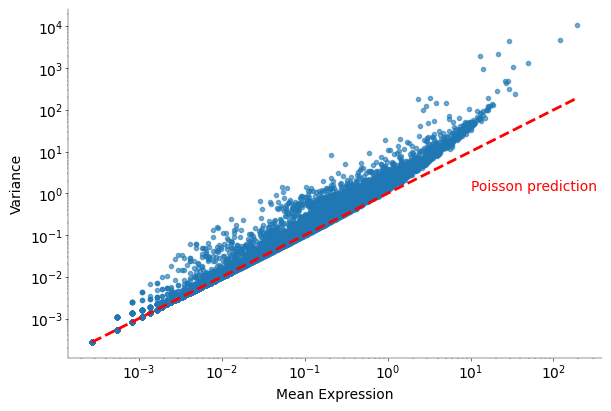

In [8]:
# Plot the mean-variance relationship on a log-log plot
# Plot the Poisson prediction as a line

fig, ax = plt.subplots(figsize=(6, 4))

# ----------------------------
# plot variance vs mean (1 pt)
# incl. computing mean and var
# ----------------------------
# Scatter plot
ax.scatter(avg_expr, var_gene, alpha=0.6)

# For poisson distribution variance/mean = 1
min_val = min(avg_expr.min(), avg_expr.min())
max_val = max(avg_expr.max(), avg_expr.max())
ax.plot([min_val, max_val], [min_val, max_val], "r--", lw=2)
ax.text(10, 1.2, "Poisson prediction", color="r")

# log scale
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Mean Expression")
ax.set_ylabel("Variance")
plt.show()

### 1.3. Relationship between the mean and the Fano factor

If the expression follows the Poisson distribution, then the Fano factor (variance/mean) should be equal to 1 for all genes.

_(1pt.)_

In [9]:
# Compute the Fano factor for each gene and make a scatter plot
# of expression mean vs. Fano factor in log-log coordinates.
fano = var_gene / avg_expr

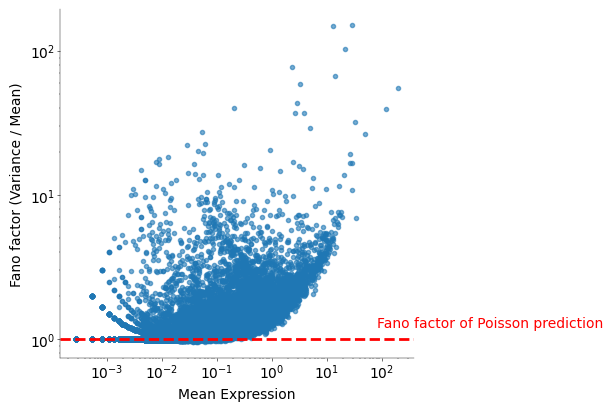

In [10]:
# Plot a Poisson prediction as line
# Use the same style of plot as above.

fig, ax = plt.subplots(figsize=(6, 4))

# -------------------------------
# plot fano-factor vs mean (1 pt)
# incl. fano factor
# -------------------------------
# Scatter plot
ax.scatter(avg_expr, fano, alpha=0.6)

# For poisson distribution variance/mean = 1
ax.axhline(1, color="r", linestyle="--", lw=2)
ax.text(80, 1.2, "Fano factor of Poisson prediction", color="r")

# log scale
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Mean Expression")
ax.set_ylabel("Fano factor (Variance / Mean)")
plt.show()

### 1.4. Histogram of sequencing depths

Different cells have different sequencing depths (sum of counts across all genes) because the efficiency can change from droplet to droplet due to some random expreimental factors.

_(1pt.)_

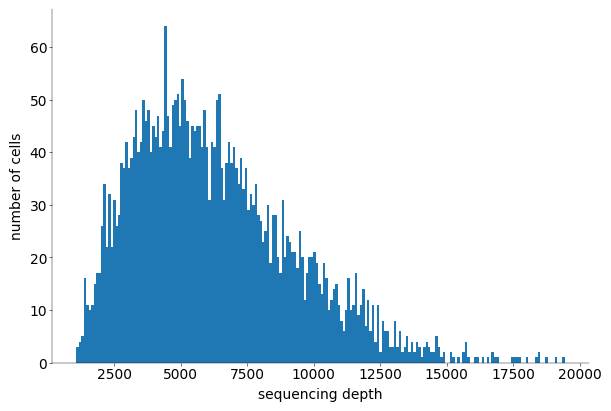

In [11]:
# Make a histogram of sequencing depths across cells.
# Sequencing depth of each cell is the sum of all counts of this cell

fig, ax = plt.subplots(figsize=(6, 4))

# ------------------------------------------
# Plot histogram of sequencing depths (1 pt)
# ------------------------------------------
ax.hist(counts.sum(axis=1), bins=200)
ax.set_xlabel("sequencing depth")
ax.set_ylabel("number of cells")
plt.show()

### 1.5. Fano factors after normalization

After normalization by sequencing depth, Fano factor should be closer to 1 (i.e. variance even more closely following the mean). This can be used for feature selection.

_(1pt.)_

In [12]:
# Normalize counts by the sequencing depth of each cell and multiply by the median sequencing depth
# Then make the same expression vs Fano factor plot as above

# -----------------------------------
# compute normalized counts (0.5 pts)
# -----------------------------------
norm_counts = (counts.T / counts.sum(axis=1)).T * np.median(counts.sum(axis=1))
norm_var = norm_counts.var(axis=0)
norm_avg = norm_counts.mean(axis=0)
norm_fano = norm_var / norm_avg

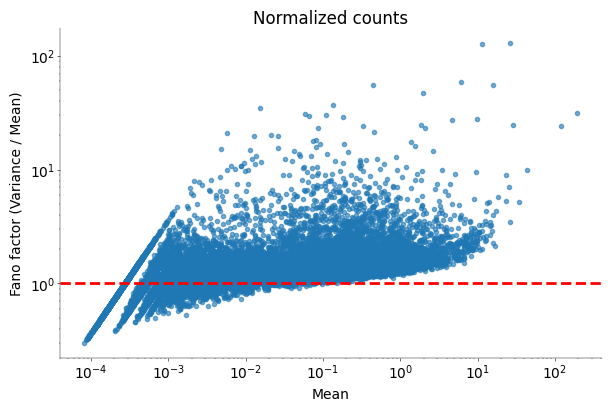

In [13]:
# ----------------------------------------------------------
# plot normalized counts and find the top 10 genes (0.5 pts)
# hint: keep appropriate axis scaling in mind
# ----------------------------------------------------------

fig, ax = plt.subplots(figsize=(6, 4))

# add plot
ax.scatter(norm_avg, norm_fano, alpha=0.6)

# For poisson distribution
ax.axhline(1, color="r", linestyle="--", lw=2)

# log scale
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("Mean")
ax.set_ylabel("Fano factor (Variance / Mean)")
ax.set_title("Normalized counts")
plt.show()

In [15]:
# Find top-10 genes with the highest normalized Fano factor
# Print them sorted by the Fano factor starting from the highest
# Gene names are stored in the `genes` array

print(genes[norm_fano.argsort()[:-11:-1]])

['Sst' 'Npy' 'Vip' 'Cck' 'Cpne2' 'Pcp4' 'Ptpn23' 'Pdzd9' 'Malat1' 'Armc2']


## 2. Low dimensional visualization

Here we look at the influence of variance-stabilizing transformations on PCA and t-SNE.

### 2.1. PCA with and without transformations

Square root is a variance-stabilizing transformation for the Poisson data. Log-transform is also often used in the transcriptomic community. Look at the effect of both.

_(1pt.)_

In [14]:
# --------------------------------------
# transform data and apply PCA (0.5 pts)
# --------------------------------------

# Transform the counts into normalized counts (as above)
# Select all genes with the normalized Fano factor above 3 and remove the rest

selected_counts = counts[:, norm_fano >= 3]

In [15]:
# Perform PCA three times: on the resulting matrix as is,
# after np.log2(X+1) transform, and after np.sqrt(X) transform

from sklearn.decomposition import PCA

# perform PCA
# 1. original PCA
pca = PCA(n_components=50)  # computing 50 PCs is less expensive for further TSNE
pca_original = pca.fit_transform(selected_counts)

# 2. log2 transformed data
data_log2 = np.log2(selected_counts + 1)
pca_log2 = pca.fit_transform(data_log2)

# 3. sqrt transformed data
data_sqrt = np.sqrt(selected_counts)
pca_sqrt = pca.fit_transform(data_sqrt)

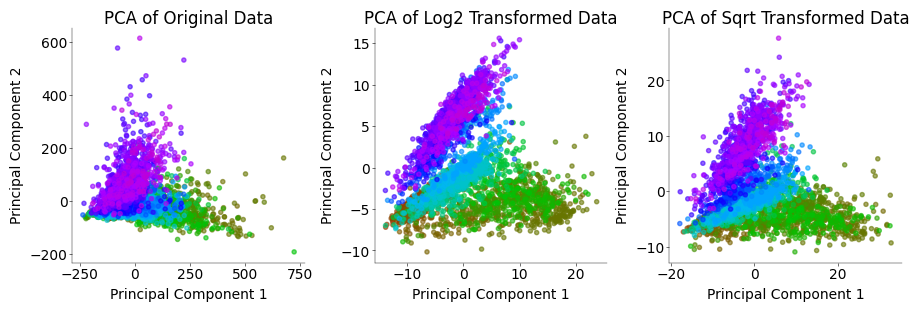

In [16]:
# -------------------------------------------
# plot first 2 PCs for each dataset (0.5 pts)
# -------------------------------------------

fig, axs = plt.subplots(1, 3, figsize=(9, 3))

cell_colors = np.array([clusterColors[cluster] for cluster in clusters])

# add plot
# Original
axs[0].scatter(pca_original[:, 0], pca_original[:, 1], alpha=0.6, c=cell_colors)
axs[0].set_title("PCA of Original Data")
axs[0].set_xlabel("Principal Component 1")
axs[0].set_ylabel("Principal Component 2")

# Log2 transformed data PCA plot
axs[1].scatter(pca_log2[:, 0], pca_log2[:, 1], alpha=0.6, c=cell_colors)
axs[1].set_title("PCA of Log2 Transformed Data")
axs[1].set_xlabel("Principal Component 1")
axs[1].set_ylabel("Principal Component 2")

# Sqrt transformed data PCA plot
axs[2].scatter(pca_sqrt[:, 0], pca_sqrt[:, 1], alpha=0.6, c=cell_colors)
axs[2].set_title("PCA of Sqrt Transformed Data")
axs[2].set_xlabel("Principal Component 1")
axs[2].set_ylabel("Principal Component 2")

plt.show()

### 2.2. tSNE with and without transformations

Do these transformations have any effect on t-SNE?

_(1pt.)_

In [17]:
# -----------------------------------------------------------------------
# Perform tSNE three times: on the resulting matrix as is,
# after np.log2(X+1) transform, and after np.sqrt(X) transform. (0.5 pts)
# -----------------------------------------------------------------------

# Apply t-SNE to the 50 PCs

# Use default settings of openTSNE
# You can also use sklearn if you want
tsne = TSNE(n_components=2)

# original
tsne_original = tsne.fit(pca_original)
# log2 transformed
tsne_log2 = tsne.fit(pca_log2)
# sqrt transformed
tsne_sqrt = tsne.fit(pca_sqrt)

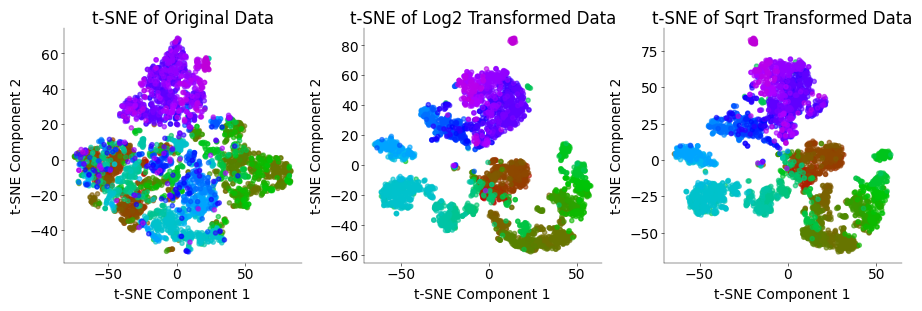

In [18]:
# -----------------------------------------------
# plot t-SNE embedding for each dataset (0.5 pts)
# -----------------------------------------------

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
# add plot
# Original
axs[0].scatter(tsne_original[:, 0], tsne_original[:, 1], alpha=0.6, c=cell_colors)
axs[0].set_title("t-SNE of Original Data")
axs[0].set_xlabel("t-SNE Component 1")
axs[0].set_ylabel("t-SNE Component 2")

# Log2 transformed data PCA plot
axs[1].scatter(tsne_log2[:, 0], tsne_log2[:, 1], alpha=0.6, c=cell_colors)
axs[1].set_title("t-SNE of Log2 Transformed Data")
axs[1].set_xlabel("t-SNE Component 1")
axs[1].set_ylabel("t-SNE Component 2")

# Sqrt transformed data PCA plot
axs[2].scatter(tsne_sqrt[:, 0], tsne_sqrt[:, 1], alpha=0.6, c=cell_colors)
axs[2].set_title("t-SNE of Sqrt Transformed Data")
axs[2].set_xlabel("t-SNE Component 1")
axs[2].set_ylabel("t-SNE Component 2")

plt.show()

### 2.3. Leiden clustering

This dataset is small and can be clustered in many different ways. We will apply Leiden clustering (closely related to the Louvain clustering), which is standard in the field and works well even for very large datasets.

_(1pt.)_

In [19]:
# To run this code you need to install leidenalg and igraph
# conda install -c conda-forge python-igraph leidenalg

import igraph as ig
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
import leidenalg as la

In [20]:
# Define some contrast colors

clusterCols = [
    "#FFFF00",
    "#1CE6FF",
    "#FF34FF",
    "#FF4A46",
    "#008941",
    "#006FA6",
    "#A30059",
    "#FFDBE5",
    "#7A4900",
    "#0000A6",
    "#63FFAC",
    "#B79762",
    "#004D43",
    "#8FB0FF",
    "#997D87",
    "#5A0007",
    "#809693",
    "#FEFFE6",
    "#1B4400",
    "#4FC601",
    "#3B5DFF",
    "#4A3B53",
    "#FF2F80",
    "#61615A",
    "#BA0900",
    "#6B7900",
    "#00C2A0",
    "#FFAA92",
    "#FF90C9",
    "#B903AA",
    "#D16100",
    "#DDEFFF",
    "#000035",
    "#7B4F4B",
    "#A1C299",
    "#300018",
    "#0AA6D8",
    "#013349",
    "#00846F",
    "#372101",
    "#FFB500",
    "#C2FFED",
    "#A079BF",
    "#CC0744",
    "#C0B9B2",
    "#C2FF99",
    "#001E09",
    "#00489C",
    "#6F0062",
    "#0CBD66",
    "#EEC3FF",
    "#456D75",
    "#B77B68",
    "#7A87A1",
    "#788D66",
    "#885578",
    "#FAD09F",
    "#FF8A9A",
    "#D157A0",
    "#BEC459",
    "#456648",
    "#0086ED",
    "#886F4C",
    "#34362D",
    "#B4A8BD",
    "#00A6AA",
    "#452C2C",
    "#636375",
    "#A3C8C9",
    "#FF913F",
    "#938A81",
    "#575329",
    "#00FECF",
    "#B05B6F",
    "#8CD0FF",
    "#3B9700",
    "#04F757",
    "#C8A1A1",
    "#1E6E00",
    "#7900D7",
    "#A77500",
    "#6367A9",
    "#A05837",
    "#6B002C",
    "#772600",
    "#D790FF",
    "#9B9700",
    "#549E79",
    "#FFF69F",
    "#201625",
    "#72418F",
    "#BC23FF",
    "#99ADC0",
    "#3A2465",
    "#922329",
    "#5B4534",
    "#FDE8DC",
    "#404E55",
    "#0089A3",
    "#CB7E98",
    "#A4E804",
    "#324E72",
    "#6A3A4C",
    "#83AB58",
    "#001C1E",
    "#D1F7CE",
    "#004B28",
    "#C8D0F6",
    "#A3A489",
    "#806C66",
    "#222800",
    "#BF5650",
    "#E83000",
    "#66796D",
    "#DA007C",
    "#FF1A59",
    "#8ADBB4",
    "#1E0200",
    "#5B4E51",
    "#C895C5",
    "#320033",
    "#FF6832",
    "#66E1D3",
    "#CFCDAC",
    "#D0AC94",
    "#7ED379",
    "#012C58",
]

clusterCols = np.array(clusterCols)

# ------------------------------------------------------
# create graph and run leiden clustering on it (0.5 pts)
# hint: use `la?`, `la.find_partition?` and `ig.Graph?`
# to find out more about the provided packages.
# ------------------------------------------------------

# Construct kNN graph with k=15
k = 15

A = NearestNeighbors(n_neighbors=k, algorithm="auto").fit(tsne_log2)
distances, indices = A.kneighbors(tsne_log2)

# Transform it into an igraph object
sources, targets = indices.nonzero()

# Initialize an empty graph
n_samples = tsne_log2.shape[0]
g = ig.Graph(n=n_samples)

# add edges
edges = []
for i in range(n_samples):
    for j in indices[i]:
        if i != j:  # Avoid self-loops
            edges.append((i, j))

g.add_edges(edges)

# weights??

In [21]:
# Run Leiden clustering
# you can use `la.RBConfigurationVertexPartition` as the partition type

partition = la.find_partition(g, la.CPMVertexPartition, resolution_parameter=1.0)

Leiden_clr = partition.membership

(-58.380996617827776,
 53.70731530712378,
 -47.187873864026415,
 51.400604339563934)

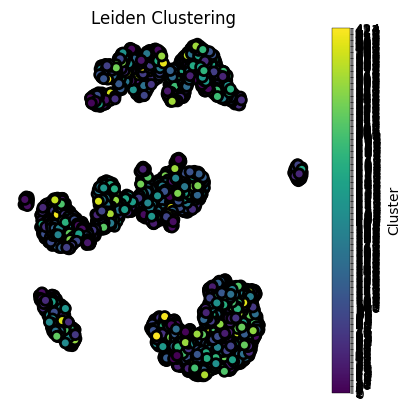

In [39]:
# --------------------------
# Plot the results (0.5 pts)
# --------------------------

fig, ax = plt.subplots(figsize=(4, 4))

# Extract coordinates from igraph layout -> matplotlib plotting instead of igraph
layout = g.layout("kk")
coords = np.array(layout.coords)

# draw edges
for edge in g.get_edgelist():
    ax.plot(
        [coords[edge[0], 0], coords[edge[1], 0]],
        [coords[edge[0], 1], coords[edge[1], 1]],
        "k-",
        alpha=0.7,
    )

# scatter with Leiden clusters
sca = ax.scatter(
    coords[:, 0],
    coords[:, 1],
    c=Leiden_clr,
    cmap="viridis",
    s=200,
    edgecolors="k",
    linewidths=2,
    zorder=2,
)

ax.set_title("Leiden Clustering")
cbar = fig.colorbar(sca, ax=ax, label="Cluster")
cbar.set_ticks(np.arange(max(Leiden_clr) + 1))  # Adjust ticks to match cluster indices

ax.axis("off")

### 2.4. Change the clustering resolution

The number of clusters can be changed by modifying the resolution parameter.

_(1pt.)_

In [41]:
# How many clusters did we get?
# Change the resolution parameter to yield 2x more and 2x fewer clusters
# Plot all three results as tSNE overlays (as above)

# ------------------------------------------------------------------
# run the clustering for 3 different resolution parameters (0.5 pts)
# ------------------------------------------------------------------

resolutions = [0.5, 1.0, 2.0]

# Perform Leiden clustering for each resolution parameter
clusterings = []
for r in resolutions:
    partition = la.find_partition(g, la.CPMVertexPartition, resolution_parameter=r)
    clusterings.append(partition)

# Print number of clusters for each resolution parameter
for i, partition in enumerate(clusterings):
    num_clusters = len(set(partition.membership))
    print(f"Resolution {resolutions[i]}: Number of clusters = {num_clusters}")

Resolution parameter 0.5: Number of clusters = 271
Resolution parameter 1.0: Number of clusters = 429
Resolution parameter 2.0: Number of clusters = 3663


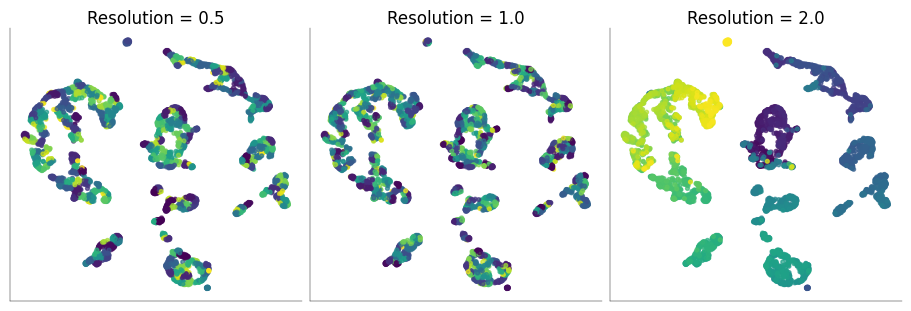

In [45]:
# --------------------------
# Plot the results (0.5 pts)
# --------------------------

fig, axs = plt.subplots(1, 3, figsize=(9, 3))

# add plot
# Extract coordinates from igraph layout -> matplotlib plotting instead of igraph
layout = g.layout("kk")
coords = np.array(layout.coords)

# Perform t-SNE to visualize clusters
tsne = TSNE(n_components=2)
tsne_coords = tsne.fit(coords)

# t-SNE plots
for i, partition in enumerate(clusterings):
    ax = axs[i]
    ax.scatter(
        tsne_coords[:, 0],
        tsne_coords[:, 1],
        c=partition.membership,
        cmap="viridis",
        s=30,
        alpha=0.7,
    )
    ax.set_title(f"Resolution = {resolutions[i]}")
    ax.set_xticks([])
    ax.set_yticks([])